# **Solar Radiation Forecasting MIAR**
###Dans le cadre du Master en IA et Robotique de l'Université des Mascareignes, cette partie du projet consiste à effectuer la prévision de la radiation solaire par l'IA en utilisant des données en temps réel du station météorologique du projet ***IOS-net*** *(**I**ndian **O**cean **S**olar **net**work)* de l'ENERGY-Lab de l'Université de La Réunion installé à ***Vacoas Mauritius***. 
###Les données seront collecté en format netCDF(**net**work **C**ommon **D**ata **F**orm) à travers le serveur TDS, outil de big data supportant ce format particulier dont l'avanage est de permettre de contenir les metadata.

###**NB :** Les données du station météorologique de Vacoas sont logged journalièrement au seveur TDS à compté du *19-10-2019 jusqu'à actuelle.*

# **I- Data Collection** (Accès aux fichier netCDF sur le serveur TDS du IOS-net)


##1- Installation des packages 

In [ ]:
! pip install siphon
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install urllib3
! pip install netCDF4

     |████████████████████████████████| 69 kB 2.7 MB/s 


##2- Importation des modules

In [ ]:
from datetime import datetime, timedelta
import os.path, os
from siphon.catalog import TDSCatalog
from urllib.error import HTTPError
import pandas as pd
# Import some visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
tds_url = 'https://galilee.univ-reunion.fr/thredds/catalog/dataStations/'

##3- Accéder au metadata
Le code ci dessous nous permet de visualiser les metada et ainsi les variables contenu dans chacun de nos fichier netCDF.

In [ ]:
tds_base_url = f'{tds_url}/catalog.xml'

# Access the TDS catalogue 
print(f'Requesting {tds_base_url} ...')
cat_base = TDSCatalog(tds_base_url)

# Get catalogue metadata
metadata = cat_base.metadata

# List the variables and their units
variables = metadata['variables']

print('Liste des variables :')

for k,v in variables.items():
    unit = v['units']
    print(f' # {k} ({unit}) ')

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations//catalog.xml ...
Liste des variables :
 # global_horizontal_irradiance (W m-2) 
 # diffuse_horizontal_irradiance (W m-2) 
 # UV_irradiance_on_A_and_B_band (W m-2) 
 # relative_humidity (%RH) 
 # air_pressure (hPA) 
 # rainfall (mm) 
 # air_temperature (degree Celsius) 
 # dew_point_temperature (degree Celsius) 
 # wind_direction  (degree) 
 # standard_deviation_of_wind_direction (degree) 
 # wind_speed (m s-1) 
 # wind_speed_max_of_gust (m s-1) 
 # minimum_datalogger_voltage (degree Celsius) 
 # thermocouple_box_temperature (degree Celsius) 
 # datalogger_intern_temperature (degree Celsius) 
 # solar_panel_back_surface_temperature (degree Celsius) 


## 3) Accéder à distance au fichier

Les données netCDF disponible sur le serveur TDS sont générer de facon à contenir chancun des fichiers journlière.

Accessible via le lien : 
https://galilee.univ-reunion.fr/thredds/catalog/dataStations/catalog.html

###a- Analyse des données premièrement disponible sur le serveur TDS

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
Found 1 file(s) : [1572415339_2019-10-29.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


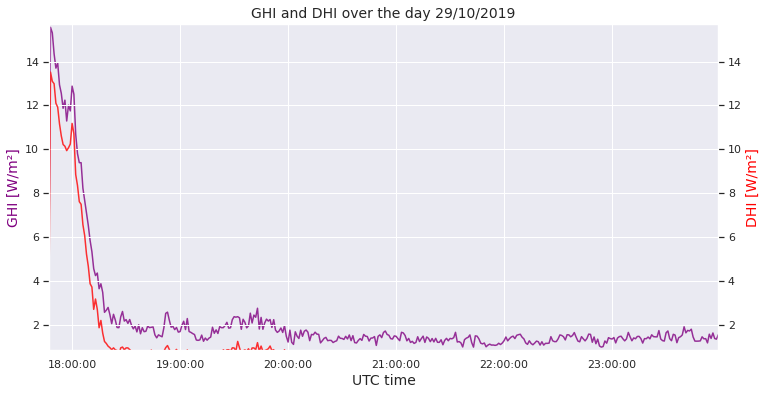

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
YEAR = 2019
MONTH = '10' # MONTH format must be a two character string : 'xx'
DAY = '29'  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Commentaire du graphe : **

Comme on voit sur le graph ci dessus, les données récoltés lors debut du lancement de la station, c-à-dire du *19-10-2019*, n'est pas complète mais commence vers *18h*, donc ne nous est pas utile pour notre projet de prévision. La raison principale c'est que les données mis à part des horraires présenté sur la courbe ci dessus, de la date 19-10-2019, sont toutes **NA**.

###b- Analyse des données dernièrement disponible sur le serveur TDS

DAY : 08
MONTH : 4
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-08.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


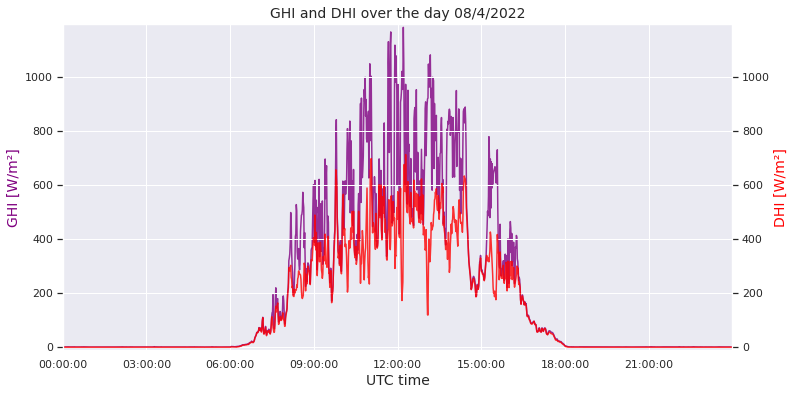

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'   
date = datetime.utcnow() 
YEAR = date.year
YEAR=2022
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Get last date logged(yesterday)
lastdate = datetime.now() + timedelta(days=-3)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
print(f'MONTH : {MONTH}')
#datetime.timedelta(days=1)
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]  

GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Voici à la courbe ci dessus, un exemple d'illustration de donnée journalière complète receillit chaque minute de la journée de hier.

Ici notre variable de sortie est le GHI (global_horizontal_irradiance) en (W/m^2)
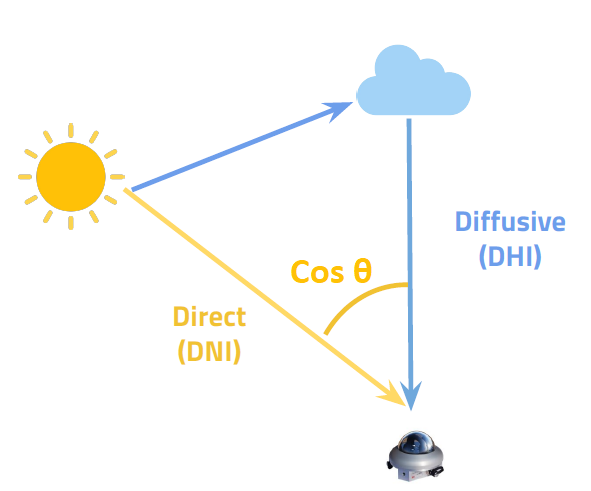


GHI = DHI + cos(𝞡) *DNI

###c- Filtrage des variables  
Ici on va choisir les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement. C'est à dire les variables d'entrer et variable de sortie de notre LSTM.

DAY : 06
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-06.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


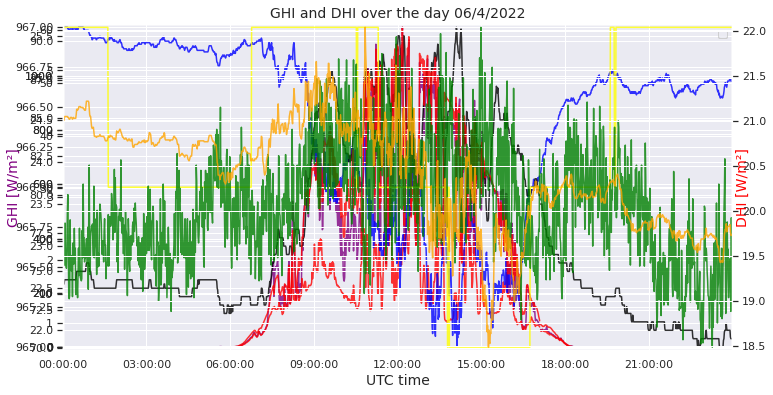

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]
P = data['air_pressure'][:]
Wind = data['wind_speed'][:]
dT = data['dew_point_temperature'][:]
# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()
ax6 = ax5.twinx()
ax7 = ax6.twinx()
ax8 = ax7.twinx()


ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='red', alpha = 0.8)
ax6.plot(T_dt, P, c='yellow', alpha = 0.8)
ax7.plot(T_dt, Wind, c='green', alpha = 0.8)
ax8.plot(T_dt, dT, c='orange', alpha = 0.8)


ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Avec :**
> - global_horizontal_irradiance (GHI) : purple
> - diffuse_horizontal_irradiance (DHI) : red
> - relative_humidity (RH) : blue
> - air_temperature (Temp) : black
> - air_pressure (P) : yellow
> - UV_irradiance_on_A_and_B_band (UV) : red
> - dew_point_temperature (dT) : orange

Le graphe des variable ci dessus nous permet de filtrer les variables qui n'ont pas de relation claire avec notre variable de sortie.

A partir de ce graphe on peut donc déduire que les variables en correlation avec notre variable de sortie GHI sont :
> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

Voici la courbe ci dessus, un exemple d'illustration des variables du metadata journalière receillit chaque minute par le station météorologique de vacoas.

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY=lastdate.day  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()



ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='green', alpha = 0.8)



ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 0 file(s) : []


IndexError: ignored

**Avec :**
> - GHI : purple
> - DHI : red
> - RH : blue
> - Temp : black
> - UV : green

###d- Sauvegarder les variables pour notre LSTM
Ici on va sauvegarder localement en sour forme de dictionnaire en format **.csv** les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement, à savoir : 

> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]
dude='1572415339_2019-10-29.nc'
for i in range(2019,date.year+1):
  
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  

  # Access the data
  print('Accessing file on server...')



> - Year 2019
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
    -> Success
Found 63 file(s) : [1572415339_2019-10-30.nc, 1572415339_2019-10-31.nc, 1572415339_2019-11-01.nc, 1572415339_2019-11-02.nc, 1572415339_2019-11-03.nc, 1572415339_2019-11-04.nc, 1572415339_2019-11-05.nc, 1572415339_2019-11-06.nc, 1572415339_2019-11-07.nc, 1572415339_2019-11-08.nc, 1572415339_2019-11-09.nc, 1572415339_2019-11-10.nc, 1572415339_2019-11-11.nc, 1572415339_2019-11-12.nc, 1572415339_2019-11-13.nc, 1572415339_2019-11-14.nc, 1572415339_2019-11-15.nc, 1572415339_2019-11-16.nc, 1572415339_2019-11-17.nc, 1572415339_2019-11-18.nc, 1572415339_2019-11-19.nc, 1572415339_2019-11-20.nc, 1572415339_2019-11-21.nc, 1572415339_2019-11-22.nc, 1572415339_2019-11-23.nc, 1572415339_2019-11-24.nc, 1572415339_2019-11-25.nc, 1572415339_2019-11-26.nc, 1572415339_2019-11-27.nc, 1572415339_2019-11-28.nc, 1572415339_2019-11-29.nc, 1572415339_2019-11-30.nc, 15724153

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]

for i in range(2019,date.year+1):
    
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("-----------------------------------------------------------")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  
  # Access the data
  print('Accessing file on server...')


  for files in selection:
  
    data = files.remote_access()
    print(f'   -> 1 Day file "{files}" Done')

    # save each netCDF files values inside 'dic' dictionnary for each .nc files(1440 values) and each year(2019-2022), and Convert unix time in a datetime format
    dic['time'].extend([ datetime.fromtimestamp(t) for t in data['time'][:]] )
    dic['GHI'].extend(data['total_horizontal_irradiance'][:])
    dic['DHI'].extend(data['diffuse_horizontal_irradiance'][:])
    dic['RH'].extend(data['relative_humidity'][:])
    dic['Temp'].extend(data['air_temperature'][:])
    dic['UV'].extend(data['UV_irradiance_on_A_and_B_band'][:])


    arr=data['total_horizontal_irradiance'][:]
    print(f'{len(arr)} values for variable "GDI" ')

    

  print(f'my_dict : {len(dic)}') 
  
 
  #convert dictionnary to dataframe
  df = pd.DataFrame(dic)
  
  #show dataframe for each files passed
  print(df)

#save dataframe to csv format
df.to_csv('iosnet_df.csv',index=False)

NameError: ignored

#4) Preparation du dataset

###Importation des variables depuis le dataset csv precedement sauvegarder
"Cancel the upload process if file is already loaded"

In [ ]:
from google.colab import files

#Upload the csv file from pc(Juste cancel si on va pas improter depuis PC)
files.upload()

#Read the csv file
df = pd.read_csv('iosnet_df.csv')
df.head()

Saving iosnet_df.csv to iosnet_df.csv


,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


Creation des nouveaux variables :
> - date
> - year
> - day
> - jday (julian day 1 à 365/366 jours)
> - hour
> - minute

In [ ]:
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


###Répartitionner la Date en year, month, day, minute

In [ ]:
df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['time']).dt.date

df['year']=df['time'].apply(lambda x: x.year)
df['month']=df['time'].apply(lambda x: x.month)
df['day']=df['time'].apply(lambda x: x.day)
df['jday'] = df['time'].apply(lambda x: x.timetuple().tm_yday )
df['hour']=df['time'].apply(lambda x: x.hour)
df['minute']=df['time'].apply(lambda x: x.minute)

df.head()


,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


Verification **NA** value

In [ ]:
#find if there are some NA value in dataset
df['GHI'].isnull().sum()

3208

###Remplacer NAN value by 0

In [ ]:
df['GHI'] = df['GHI'].fillna(int(0)) 
df['DHI'] = df['DHI'].fillna(int(0)) 
df['RH'] = df['RH'].fillna(int(0)) 
df['Temp'] = df['Temp'].fillna(int(0)) 
df['UV'] = df['UV'].fillna(0) 

In [ ]:
df.head()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231200 entries, 0 to 1231199
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1231200 non-null  datetime64[ns]
 1   GHI     1231200 non-null  float64       
 2   DHI     1231200 non-null  float64       
 3   RH      1231200 non-null  float64       
 4   Temp    1231200 non-null  float64       
 5   UV      1231200 non-null  object        
 6   date    1231200 non-null  object        
 7   year    1231200 non-null  int64         
 8   month   1231200 non-null  int64         
 9   day     1231200 non-null  int64         
 10  jday    1231200 non-null  int64         
 11  hour    1231200 non-null  int64         
 12  minute  1231200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2)
memory usage: 122.1+ MB


# II Entrainement du modèle LSTM pour single input (Multi-Step LSTM Models)





##A- Data preparation

### 1) Agreggation par jour avec un seul feature à l'entré

Comme on a des données séquentielles de chaque minutes depuis le serveur TDS de IOS-net, on va faire la moyenne pour obtenir des données plutot journalière.

Ici, on vas utilisé comme feature, le GHI à l'entré pour prédire une label GHI suivante à la sortie (une label GHI correspond à une prédiction d'une journé suivante)

In [ ]:
#Aggregation par date avec une seul feature à l'entré et une label à la sortie
df2 = df.groupby('date')['GHI'].mean()
print(df2)

date
2019-10-30    331.873003
2019-10-31    324.614169
2019-11-01    241.083911
2019-11-02    246.661104
2019-11-03    185.372197
                 ...    
2022-03-25    194.689736
2022-03-26    155.514372
2022-03-27    199.701943
2022-03-28    232.499305
2022-03-29    196.232533
Name: GHI, Length: 855, dtype: float64


In [ ]:
df2.to_csv('df2.csv',index=False)

### 4) Lire dataframe depuis csv

In [ ]:
df0 = pd.read_csv("df2.csv")
df2.head()

date
2019-10-30    331.873003
2019-10-31    324.614169
2019-11-01    241.083911
2019-11-02    246.661104
2019-11-03    185.372197
Name: GHI, dtype: float64

### 5) Verification s'il y a NAN value dans GHI column

In [ ]:
#find if there are some NA value in dataset
df0['GHI'].isnull().sum()

0

#Here we go ----------------------------------

### Import library and modules

In [ ]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from matplotlib import pyplot

###  Convert series to supervised learning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Dataset preparation

In [ ]:
# load dataset
#dataset = read_csv('df2.csv', header = 0, index_col=0)
dataset = read_csv('df2.csv')
dataset.head()


,GHI
0,331.873003
1,324.614169
2,241.083911
3,246.661104
4,185.372197


### Convertir notre pandas dataframe vers numpy array

In [ ]:

values=dataset.to_numpy()
print(f'values : \n {values}')


values : 
 [[331.87300347]
 [324.61416875]
 [241.08391111]
 [246.66110417]
 [185.37219722]
 [287.75547986]
 [187.23606111]
 [344.91790417]
 [319.33625347]
 [341.53321528]
 [206.83888542]
 [167.12397361]
 [229.13823472]
 [188.85222847]
 [159.83134375]
 [266.93486806]
 [195.80280694]
 [247.15537917]
 [262.96090486]
 [206.39283611]
 [185.05972014]
 [237.23991597]
 [137.75955139]
 [236.38109444]
 [202.57577014]
 [204.58381042]
 [261.69881042]
 [161.64869653]
 [210.44370208]
 [185.86215694]
 [205.91690486]
 [261.82353958]
 [306.02848264]
 [325.22889375]
 [319.48956944]
 [292.90968889]
 [179.89472083]
 [192.95370208]
 [234.38025139]
 [278.26813194]
 [281.44141875]
 [150.91558264]
 [217.34650347]
 [240.29929097]
 [236.53588472]
 [224.34307361]
 [312.09285208]
 [262.92897361]
 [274.54464931]
 [201.22064861]
 [194.04684722]
 [269.74808958]
 [321.46742778]
 [323.53701389]
 [268.00682778]
 [322.72848681]
 [306.63284236]
 [180.96253681]
 [227.60145347]
 [248.07400972]
 [131.14103333]
 [ 41.6936965

In [ ]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
n_mins = 1
n_features = 1
reframed = series_to_supervised(scaled, n_mins, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[-24:-1], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


(849, 12)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.906585   0.885648   0.644718   0.660805   0.484027   0.779335  0.885648   
2   0.885648   0.644718   0.660805   0.484027   0.779335   0.489403  0.644718   
3   0.644718   0.660805   0.484027   0.779335   0.489403   0.944210  0.660805   
4   0.660805   0.484027   0.779335   0.489403   0.944210   0.870424  0.484027   
5   0.484027   0.779335   0.489403   0.944210   0.870424   0.934448  0.779335   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.644718  0.660805  0.484027  0.779335  0.489403  
2  0.660805  0.484027  0.779335  0.489403  0.944210  
3  0.484027  0.779335  0.489403  0.944210  0.870424  
4  0.779335  0.489403  0.944210  0.870424  0.934448  
5  0.489403  0.944210  0.870424  0.934448  0.545944  


### Split into train and test sets

In [ ]:
values = reframed.values
n_train_mins = 700
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]

# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y =test[:, :n_obs], test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_mins, n_features))
test_X = test_X.reshape((test_X.shape[0], n_mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(700, 1, 1) (700,) (149, 1, 1) (149,)


### Design network

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

layers = [0,500,0,0,1]
model = Sequential()

model.add(LSTM(layers[1],	input_shape=(train_X.shape[1], train_X.shape[2]),	return_sequences=False))
model.add(Dropout(0.5))

#model.add(LSTM(
#        layers[2],
#        return_sequences=False))
#model.add(Dropout(0.2))

#model.add(LSTM(
#        layers[3],
#        return_sequences=False))
#model.add(Dropout(0.5))

model.add(Dense(layers[4]))
model.add(Activation("linear"))

model.compile(loss='mae', optimizer='adam')

es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# fit network
history = model.fit(train_X, train_y, epochs = 500, batch_size=2, validation_data=(test_X, test_y), callbacks=es, verbose=2, shuffle=False)

Epoch 1/500
350/350 - 6s - loss: 0.1584 - val_loss: 0.1633 - 6s/epoch - 16ms/step
Epoch 2/500
350/350 - 4s - loss: 0.1293 - val_loss: 0.1672 - 4s/epoch - 10ms/step
Epoch 3/500
350/350 - 4s - loss: 0.1257 - val_loss: 0.1739 - 4s/epoch - 10ms/step
Epoch 4/500
350/350 - 3s - loss: 0.1259 - val_loss: 0.1715 - 3s/epoch - 10ms/step
Epoch 5/500
350/350 - 3s - loss: 0.1265 - val_loss: 0.1708 - 3s/epoch - 9ms/step
Epoch 6/500
350/350 - 3s - loss: 0.1296 - val_loss: 0.1688 - 3s/epoch - 9ms/step
Epoch 7/500
350/350 - 3s - loss: 0.1298 - val_loss: 0.1843 - 3s/epoch - 9ms/step
Epoch 8/500
350/350 - 3s - loss: 0.1298 - val_loss: 0.1687 - 3s/epoch - 9ms/step
Epoch 9/500
350/350 - 3s - loss: 0.1303 - val_loss: 0.1787 - 3s/epoch - 9ms/step
Epoch 10/500
350/350 - 3s - loss: 0.1315 - val_loss: 0.1804 - 3s/epoch - 9ms/step
Epoch 11/500
350/350 - 3s - loss: 0.1285 - val_loss: 0.1804 - 3s/epoch - 9ms/step
Epoch 12/500
350/350 - 3s - loss: 0.1307 - val_loss: 0.1950 - 3s/epoch - 9ms/step
Epoch 13/500
350/350 

### Plot history

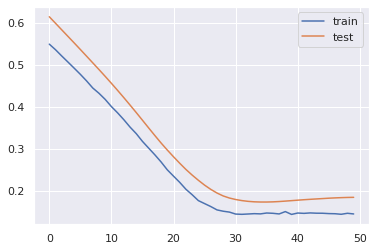

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))
print(yhat.shape,test_X.shape)

# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAPE
mape = np.mean(np.fabs((inv_y - inv_yhat +1) / (inv_y+1))) * 100
print('Test mape: %d' % mape)

index = [0,100,200,300,400,500,600,700,800,900]
for i in index:
	print('y = %.3f' % inv_y[i])
	print('yhat = %.3f' % inv_yhat[i])
 

ValueError: ignored

### Plot

In [ ]:
pyplot.plot([x for x in range(1,inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([x for x in range(1,inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#Next step -----------------------------------

### 2) Split data en train and test set en utilisant sklearn 
Avec 80% pour training et 20% pour test set

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

df_train,df_test = train_test_split(df2,test_size=0.2,random_state=0,shuffle=False,stratify=None)
print(f'df_train :\n {df_train}\n')
print(f'df_test :\n {df_test}')

df_train :
                    GHI         DHI       Temp         RH
date                                                    
2019-10-30  331.873003   42.739549  20.065535  73.615660
2019-10-31  324.614169   63.528711  20.462312  75.093167
2019-11-01  241.083911  102.843759  21.215368  75.289868
2019-11-02  246.661104  154.958376  19.008174  83.510493
2019-11-03  185.372197  131.939922  18.774153  89.260000
...                ...         ...        ...        ...
2021-09-08  188.063941  110.289231  17.017118  85.715792
2021-09-09  170.830477  129.406044  18.031646  85.391354
2021-09-10  290.353052   29.762483  19.423167  74.918813
2021-09-11  187.446535  109.564174  18.570833  84.113472
2021-09-12  207.995503  110.492606  18.745021  81.786792

[684 rows x 4 columns]

df_test :
                    GHI         DHI       Temp         RH
date                                                    
2021-09-13  138.406569  121.592377  17.937528  85.917201
2021-09-14  200.961802  112.434359  18.1

### 3) Export data train & test dataframe to csv

In [ ]:
df_train.to_csv('df_train.csv',index=False)
df_test.to_csv('df_test.csv',index=False)
print(f"Done to export df_train & df_test !")

Done to export df_train & df_test !


### 4) Lecture dataframe depuis csv **df_train** & **df_train**, précedement générer

In [ ]:
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")
df_train.head()

,GHI,DHI,Temp,RH
0,331.873003,42.739549,20.065535,73.615660
1,324.614169,63.528711,20.462312,75.093167
2,241.083911,102.843759,21.215368,75.289868
3,246.661104,154.958376,19.008174,83.510493
4,185.372197,131.939922,18.774153,89.260000


### 5) Maintenant, il est temps de convertir nos pandas dataframes vers numpy array


In [ ]:
#Convertir notre pandas dataframe vers numpy array
df_train=df_train.to_numpy()
df_test=df_test.to_numpy()
print(f'df_train : \n {df_train}')
print(f'df_test : \n {df_test}')

df_train : 
 [[331.87300347  42.73954931  20.06553472  73.61565972]
 [324.61416875  63.52871111  20.4623125   75.09316667]
 [241.08391111 102.84375903  21.21536806  75.28986806]
 ...
 [290.35305208  29.76248264  19.42316667  74.9188125 ]
 [187.44653472 109.56417361  18.57083333  84.11347222]
 [207.99550347 110.49260625  18.74502083  81.78679167]]
df_test : 
 [[138.40656944 121.59237708  17.93752778  85.91720139]
 [200.96180208 112.43435903  18.18442361  81.52664583]
 [208.91037222 104.76002153  18.7583125   81.80548611]
 [184.59781111 114.24187153  18.98111111  84.82295139]
 [200.71418125 115.82353056  19.56688194  82.50688889]
 [156.93195972 108.76454931  19.8079375   83.97113194]
 [273.80066875  66.31725278  18.62595833  75.02679861]
 [251.95162292  91.09008819  17.342       76.50470139]
 [304.59370764  34.69096181  17.897       73.17979861]
 [277.03809097  89.56396806  18.08463889  77.34160417]
 [236.33227153 121.24231042  19.01449306  81.77470833]
 [219.14661528 101.82973889  19.56

Convert numpy float to int

In [ ]:
df_train = df_train.astype(int)
df_test = df_test.astype(int)
print(f'df_train : \n {df_train}')
print(f'df_test : \n {df_test}')

df_train : 
 [[331  42  20  73]
 [324  63  20  75]
 [241 102  21  75]
 ...
 [290  29  19  74]
 [187 109  18  84]
 [207 110  18  81]]
df_test : 
 [[138 121  17  85]
 [200 112  18  81]
 [208 104  18  81]
 [184 114  18  84]
 [200 115  19  82]
 [156 108  19  83]
 [273  66  18  75]
 [251  91  17  76]
 [304  34  17  73]
 [277  89  18  77]
 [236 121  19  81]
 [219 101  19  82]
 [266  88  19  79]
 [256  87  19  83]
 [296  48  19  79]
 [247 113  18  74]
 [279  93  19  73]
 [180 120  19  80]
 [188 132  19  77]
 [223 124  19  79]
 [201 141  18  84]
 [215 119  19  83]
 [170 126  19  82]
 [118  67  19  84]
 [271 102  20  79]
 [310  54  19  71]
 [241  94  19  83]
 [249 136  20  87]
 [103 100  20  90]
 [150  90  21  83]
 [144 125  20  86]
 [288  74  20  77]
 [261 113  20  78]
 [234 112  19  80]
 [217 131  19  85]
 [239 131  20  79]
 [215 121  20  80]
 [192  94  20  78]
 [222 146  20  82]
 [203 152  21  82]
 [237 134  21  81]
 [208 126  21  79]
 [246 121  20  78]
 [260 115  20  80]
 [272 107  20  75]


### 6) Data processing
Ici on va faire en sorte de restructruré notre dataset afin d'utilisé une historique d'une semaine(7jours) pour faire la prédiction du jour suivant pour notre entrainement.

Donc on veut avoir :

* **x_train, x_test :** 4D array de forme : (len(x_train), 7 jours, les 4 features , 1)
* **y_train, y_test :** 1D array 


In [ ]:
# Naive LSTM to learn seven-val window to one-val mapping
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# definir le nombre de séquence
seq_length = 7

x_train=[]
x_test=[]
y_train=[]
y_test=[]

# definir le generateur
#nombre de feature ,ici on a pris des variables de 7 jours pour prédire variables d'1 jour, 
#Avec un 'batch_size =1' correspondant au nombre de repétition des groupes de 7 jours de notre features : [GHI,DHI,Temp,RH]*7jour => GHI du 8 èm jour
generator_train = TimeseriesGenerator(df_train, df_train, length=seq_length, batch_size=1)
generator_test = TimeseriesGenerator(df_test, df_test, length=seq_length, batch_size=1)

# Nombre d'échantillon
print(f'Samples_train: {len(generator_train)}\n')


#Générer la partie entrainement
for i in range(len(generator_train)):
  x, y = generator_train[i]
  y=y[0,0]
 
  x_train.append(x)
  y_train.append(y)
  
#Générer la partie test
for i in range(len(generator_test)):
  x, y = generator_test[i]
  y=y[0,0]
  x_test.append(x)
  y_test.append(y)
  
print(f'x_train : \n {x_train}')
print(f'y_train : \n {y_train}')

Samples_train: 677

x_train : 
 [array([[[331,  42,  20,  73],
        [324,  63,  20,  75],
        [241, 102,  21,  75],
        [246, 154,  19,  83],
        [185, 131,  18,  89],
        [287,  83,  20,  83],
        [187,  81,  21,  80]]]), array([[[324,  63,  20,  75],
        [241, 102,  21,  75],
        [246, 154,  19,  83],
        [185, 131,  18,  89],
        [287,  83,  20,  83],
        [187,  81,  21,  80],
        [344,  79,  21,  79]]]), array([[[241, 102,  21,  75],
        [246, 154,  19,  83],
        [185, 131,  18,  89],
        [287,  83,  20,  83],
        [187,  81,  21,  80],
        [344,  79,  21,  79],
        [319,  62,  21,  76]]]), array([[[246, 154,  19,  83],
        [185, 131,  18,  89],
        [287,  83,  20,  83],
        [187,  81,  21,  80],
        [344,  79,  21,  79],
        [319,  62,  21,  76],
        [341,  52,  20,  75]]]), array([[[185, 131,  18,  89],
        [287,  83,  20,  83],
        [187,  81,  21,  80],
        [344,  79,  21,  

### 7) Modèle LSTM pour sur 4 variables d'entrées avec 7 jours d'historique 

In [ ]:
# LSTM to learn seven-char window to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# fix random seed for reproducibility
numpy.random.seed(7)

# define the sequence lenght
seq_length = 7

# reshape X to be [samples, time steps, features, 1]
X = numpy.reshape(x_train, (len(x_train), seq_length, 4, 1))

# normalize
X = X / float(len(df_train))

# one hot encode the output variable
y = np_utils.to_categorical(y_train) 

# create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=500, batch_size=1, verbose=2, validation_data=(x_test, y_test))

# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

# demonstrate some model predictions
for pattern in x_test:
    x = numpy.reshape(pattern, (1, seq_length, 4))  
    #4 because 4 features at the input 
    #seq_length(=7) beacause we wanna use 7 day historical 
     
    x = x / float(len(df_train))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = index
    
    print(pattern, "->", result)
    print('\n')

Epoch 1/500
677/677 - 5s - loss: 5.8233 - accuracy: 0.0089 - 5s/epoch - 7ms/step
Epoch 2/500
677/677 - 2s - loss: 5.4233 - accuracy: 0.0074 - 2s/epoch - 4ms/step
Epoch 3/500
677/677 - 3s - loss: 5.3414 - accuracy: 0.0148 - 3s/epoch - 4ms/step
Epoch 4/500
677/677 - 2s - loss: 5.3227 - accuracy: 0.0148 - 2s/epoch - 3ms/step
Epoch 5/500
677/677 - 2s - loss: 5.3146 - accuracy: 0.0133 - 2s/epoch - 3ms/step
Epoch 6/500
677/677 - 2s - loss: 5.3062 - accuracy: 0.0118 - 2s/epoch - 3ms/step
Epoch 7/500
677/677 - 2s - loss: 5.2835 - accuracy: 0.0162 - 2s/epoch - 3ms/step
Epoch 8/500
677/677 - 2s - loss: 5.2253 - accuracy: 0.0118 - 2s/epoch - 3ms/step
Epoch 9/500
677/677 - 2s - loss: 5.1628 - accuracy: 0.0148 - 2s/epoch - 3ms/step
Epoch 10/500
677/677 - 2s - loss: 5.1254 - accuracy: 0.0162 - 2s/epoch - 3ms/step
Epoch 11/500
677/677 - 2s - loss: 5.0977 - accuracy: 0.0118 - 2s/epoch - 3ms/step
Epoch 12/500
677/677 - 2s - loss: 5.0701 - accuracy: 0.0222 - 2s/epoch - 3ms/step
Epoch 13/500
677/677 - 2s

D'après ce résultat vis à vis du nouvelle performance avec bien meilleur **accuracy** qui est monté jusquà plus de **'91%'** comparé à notre dernière entrainement, on peut donc conclure que le choix de considérer multiples variables d'entré **(GHI,DHI,Temp,RH)** sur notre modèle, augmente considerablement sa performance.

###Code pour juste pour tester si notre numpy shape est cohérente

In [ ]:
y_test[0]

251.95162291666668

In [ ]:
cvscores = []

for pattern in x_test:
    i=0
    x = numpy.reshape(pattern, (1, 7,4))
    x = x / float(len(df_train))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = index
    
    print(pattern, "->", result)
    print('\n')
    


[[[138.40656944 121.59237708  17.93752778  85.91720139]
  [200.96180208 112.43435903  18.18442361  81.52664583]
  [208.91037222 104.76002153  18.7583125   81.80548611]
  [184.59781111 114.24187153  18.98111111  84.82295139]
  [200.71418125 115.82353056  19.56688194  82.50688889]
  [156.93195972 108.76454931  19.8079375   83.97113194]
  [273.80066875  66.31725278  18.62595833  75.02679861]]] -> 237


[[[200.96180208 112.43435903  18.18442361  81.52664583]
  [208.91037222 104.76002153  18.7583125   81.80548611]
  [184.59781111 114.24187153  18.98111111  84.82295139]
  [200.71418125 115.82353056  19.56688194  82.50688889]
  [156.93195972 108.76454931  19.8079375   83.97113194]
  [273.80066875  66.31725278  18.62595833  75.02679861]
  [251.95162292  91.09008819  17.342       76.50470139]]] -> 238


[[[208.91037222 104.76002153  18.7583125   81.80548611]
  [184.59781111 114.24187153  18.98111111  84.82295139]
  [200.71418125 115.82353056  19.56688194  82.50688889]
  [156.93195972 108.764549

#IV Amélioré la structure de notre modèle LSTM
Maintenant qu'on connait la meilleur structure pour notre dataset pour maximisé la performance de notre modèle LSTM, on va maintenant jouer sur l'amélioration de notre architecture du réseau LSTM pour trouver un configuration optimale pour notre prévision solaire.

In [ ]:
df2

,GHI,DHI,Temp,RH
date,,,,
2019-10-30,331.873003,42.739549,20.065535,73.615660
2019-10-31,324.614169,63.528711,20.462312,75.093167
2019-11-01,241.083911,102.843759,21.215368,75.289868
2019-11-02,246.661104,154.958376,19.008174,83.510493
2019-11-03,185.372197,131.939922,18.774153,89.260000
...,...,...,...,...
2022-03-25,194.689736,83.391425,24.246563,79.994167
2022-03-26,155.514372,74.803532,24.486354,81.808437
2022-03-27,199.701943,64.447634,24.202146,80.360028


In [ ]:
X.shape[2]

4

In [ ]:
# LSTM to learn seven-char window to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
# fix random seed for reproducibility
numpy.random.seed(7)

# define the sequence lenght
seq_length = 7

# reshape X to be [samples, time steps, features, 1]
X = numpy.reshape(x_train, (len(x_train), seq_length, 4, 1))

# normalize
X = X / float(len(df_train))

# one hot encode the output variable
y = np_utils.to_categorical(y_train) 

# create and fit the model
model = Sequential()
model.add(LSTM(units=800,  input_shape=(X.shape[1],  X.shape[2])))
# Adding a second LSTM layer and some Dropout regularisation
#model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.2))

model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

# demonstrate some model predictions
for pattern in x_test:
    x = numpy.reshape(pattern, (1, seq_length, 4))  
    #4 because 4 features at the input 
    #seq_length(=7) beacause we wanna use 7 day historical 
     
    x = x / float(len(df_train))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = index
    
    print(pattern, "->", result)
    print('\n')

Epoch 1/100
677/677 - 47s - loss: 5.8312 - accuracy: 0.0059 - 47s/epoch - 69ms/step
Epoch 2/100
677/677 - 45s - loss: 5.4470 - accuracy: 0.0133 - 45s/epoch - 67ms/step
Epoch 3/100
677/677 - 45s - loss: 5.3709 - accuracy: 0.0148 - 45s/epoch - 67ms/step
Epoch 4/100
677/677 - 45s - loss: 5.3418 - accuracy: 0.0162 - 45s/epoch - 67ms/step
Epoch 5/100
677/677 - 45s - loss: 5.3272 - accuracy: 0.0103 - 45s/epoch - 66ms/step
Epoch 6/100
677/677 - 44s - loss: 5.3020 - accuracy: 0.0148 - 44s/epoch - 65ms/step
Epoch 7/100
677/677 - 45s - loss: 5.2747 - accuracy: 0.0089 - 45s/epoch - 67ms/step
Epoch 8/100
677/677 - 46s - loss: 5.2141 - accuracy: 0.0089 - 46s/epoch - 67ms/step
Epoch 9/100
677/677 - 45s - loss: 5.1583 - accuracy: 0.0207 - 45s/epoch - 67ms/step
Epoch 10/100
677/677 - 44s - loss: 5.1090 - accuracy: 0.0118 - 44s/epoch - 65ms/step
Epoch 11/100
677/677 - 45s - loss: 5.0630 - accuracy: 0.0192 - 45s/epoch - 67ms/step
Epoch 12/100
677/677 - 45s - loss: 5.0017 - accuracy: 0.0266 - 45s/epoch -

In [ ]:
# LSTM to learn seven-char window to one-char mapping
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# fix random seed for reproducibility
numpy.random.seed(7)

# define the sequence lenght
seq_length = 7

# reshape X to be [samples, time steps, features, 1]
X = numpy.reshape(x_train, (len(x_train), seq_length, 4, 1))

# normalize
X = X / float(len(df_train))

# one hot encode the output variable
y = np_utils.to_categorical(y_train) 

# create and fit the model
model = Sequential()
model.add(LSTM(1000, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], input_dim=8, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)

# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

# demonstrate some model predictions
for pattern in x_test:
    x = numpy.reshape(pattern, (1, seq_length, 4))  
    #4 because 4 features at the input 
    #seq_length(=7) beacause we wanna use 7 day historical 
     
    x = x / float(len(df_train))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = index
    
    print(pattern, "->", result)
    print('\n')

Epoch 1/500
677/677 - 52s - loss: 5.8186 - accuracy: 0.0103 - 52s/epoch - 77ms/step
Epoch 2/500
677/677 - 49s - loss: 5.4447 - accuracy: 0.0074 - 49s/epoch - 72ms/step
Epoch 3/500
677/677 - 49s - loss: 5.3634 - accuracy: 0.0133 - 49s/epoch - 73ms/step
Epoch 4/500
677/677 - 49s - loss: 5.3338 - accuracy: 0.0089 - 49s/epoch - 72ms/step
Epoch 5/500
677/677 - 49s - loss: 5.3095 - accuracy: 0.0177 - 49s/epoch - 73ms/step
Epoch 6/500
677/677 - 48s - loss: 5.2772 - accuracy: 0.0177 - 48s/epoch - 72ms/step
Epoch 7/500
677/677 - 50s - loss: 5.2208 - accuracy: 0.0089 - 50s/epoch - 74ms/step
Epoch 8/500
677/677 - 49s - loss: 5.1460 - accuracy: 0.0133 - 49s/epoch - 73ms/step
Epoch 9/500
677/677 - 49s - loss: 5.0233 - accuracy: 0.0148 - 49s/epoch - 73ms/step
Epoch 10/500
677/677 - 50s - loss: 4.8980 - accuracy: 0.0310 - 50s/epoch - 73ms/step
Epoch 11/500
677/677 - 49s - loss: 4.7245 - accuracy: 0.0295 - 49s/epoch - 72ms/step
Epoch 12/500
677/677 - 50s - loss: 4.5160 - accuracy: 0.0266 - 50s/epoch -

In [ ]:
def plot_loss(history, val_data):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=hist['epoch'],
                            y=hist['loss'],
                            name='Training Loss'),       
                         )
    if val_data == True:    
        fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )

    fig.update_layout(title='Training Result')
    fig.show()

In [ ]:
plot_loss(hist, val_data=True)

###This was not a bad performance at all, given the few iterations! Nonetheless, we will try to further optimize the model with increasing lstm cells and number of epochs to 50

In [ ]:
# We will increase the LSTM layer and also the number of epochs.
n_steps = 10
n_features=1
model2 = Sequential()
model2.add(layers.LSTM(10, activation='relu', input_shape=(n_steps, n_features)))                
model2.add(layers.Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size =10
EPOCHS=50
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history2 = model1.fit(X_train_10, y_train_10, 
                validation_data=(X_val_10, y_val_10), callbacks=es,
                epochs=EPOCHS, batch_size=batch_size, verbose=2)
IPython.display.clear_output()

In [ ]:
def plot_loss(history, val_data):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=hist['epoch'],
                            y=hist['loss'],
                            name='Training Loss'),       
                         )
    if val_data == True:    
        fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )

    fig.update_layout(title='Training Result')
    fig.show()

In [ ]:
plot_loss(history2, val_data=True)

Slightly worse than the test1. Let's check how the model predict on the test and training set.

In [ ]:
# Initialising the RNN
regressor = Sequential()

testPredict = regressor.predict(X_test_10, batch_size=32)
testPredict = scaler_d.inverse_transform(testPredict)

trainPredict = regressor.predict(X_train_10, batch_size=32)
trainPredict = scaler_d.inverse_transform(trainPredict)

ValueError: ignored

In [ ]:
def create_pred_df(true_series, prediction):
    
    df_temp = pd.DataFrame(true_series, columns=['GHI']).reset_index()
    predicted_series = pd.Series(prediction.reshape(-1))
    df_temp['predicted'] = pd.Series(predicted_series, index = df_temp.index)
    
    df_pred = pd.DataFrame(true_series, columns=['GHI'])
    df_pred['predicted'] = df_temp['predicted'].values
    
    return df_pred

In [ ]:
df_pred_test = create_pred_df(test_d_1d, testPredict)
df_pred_train = create_pred_df(train_d_1d, trainPredict)

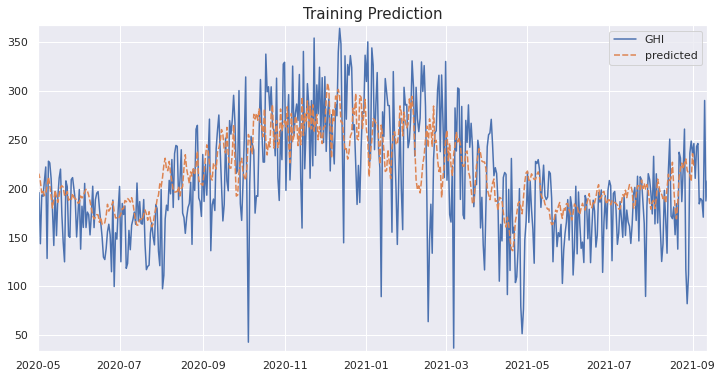

In [ ]:
# Training Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_train[-500:])
plt.title('Training Prediction', fontsize=15)
plt.legend()
plt.show();

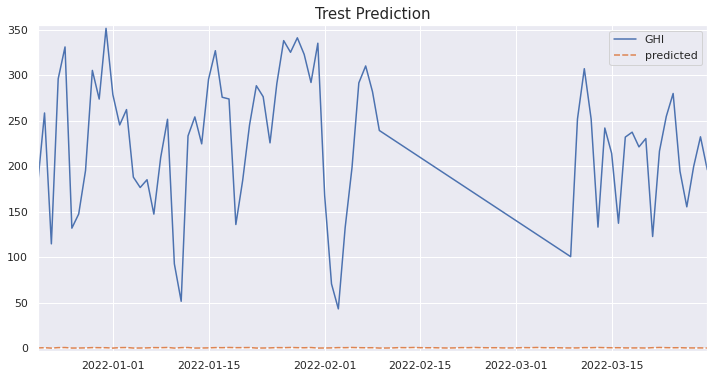

In [ ]:
# Test Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_test[-500:])
plt.title('Trest Prediction', fontsize=15)
plt.legend()
plt.show();

The second test is definitely going in the right direction. Let's further optimize the lstm framework if it can perform better. Before that, I would like to save the weights of the model.

In [ ]:
regressor.save('models/model0.h5')

In [ ]:
# Test loading model
model2_lag10 = load_model('models/model0.h5')

In [ ]:
testPredict = model2_lag10.predict(X_test_10, batch_size=32)
testPredict = scaler_d.inverse_transform(testPredict)

trainPredict = model2_lag10.predict(X_train_10, batch_size=32)
trainPredict = scaler_d.inverse_transform(trainPredict)

df_pred_test2 = create_pred_df(test_d_1d, testPredict)
df_pred_train2 = create_pred_df(train_d_1d, trainPredict)

ValueError: ignored

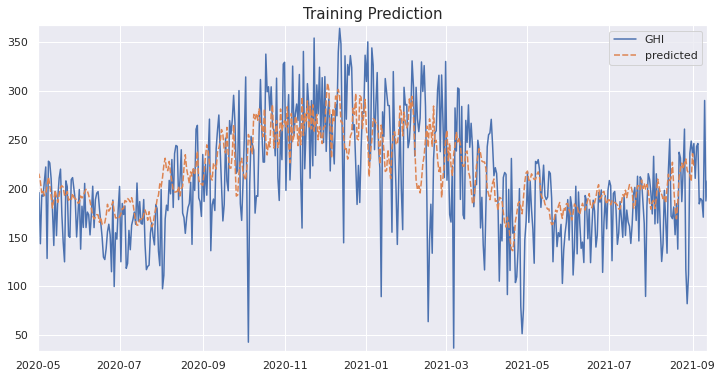

In [ ]:
# Training Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_train[-500:])
plt.title('Training Prediction', fontsize=15)
plt.legend()
plt.show();

Model is loaded properly!

In [ ]:
testPredict3 = regressor.predict(X_test_10, batch_size=10)
testPredict3 = scaler_d.inverse_transform(testPredict3)

trainPredict3 = regressor.predict(X_train_10, batch_size=10)
trainPredict3 = scaler_d.inverse_transform(trainPredict3)

ValueError: ignored

In [ ]:
df_pred_test3 = create_pred_df(test_d_1d, testPredict3)
df_pred_train3 = create_pred_df(train_d_1d, trainPredict3)

In [ ]:
df_pred_test3.tail()

NameError: ignored

In [ ]:
mae_train_lstm_lag10 = mean_absolute_error(df_pred_train3['GDI'], df_pred_train3['predicted'].fillna(0))
mae_test_lstm_lag10 = mean_absolute_error(df_pred_test3['GDI'], df_pred_test3['predicted'].fillna(0))

print(f'Training Mean Absolute Error LSTM with lag 10: {mae_train_lstm_lag10}')
print(f'Test Mean Absolute Error LSTM with lag 10: {mae_test_lstm_lag10}')

ValueError: ignored

In [ ]:
# We will increase the LSTM layer and also the number of epochs.
n_steps = 10
n_features=1
model2 = Sequential()
model2.add(layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))                
model2.add(layers.Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def run_model(model, X_train, y_train, X_val, y_val, epochs):
    batch_size =10
    es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), callbacks=es,
                    epochs=epochs, batch_size=batch_size, verbose=2)
    IPython.display.clear_output()
    return history, model

In [ ]:
history2, model2 = run_model(model2, X_train_10, y_train_10, X_val_10, y_val_10, epochs=50)
plot_loss(history2, val_data=True)

In [ ]:
# Now we will increase the # lstm cells to 100 in the first layer 
# and also add another lstm layer with 50 cells
# Finally, we will run this model for 100 iterations.

n_steps = 10
n_features=1

model3 = Sequential()
model3.add(layers.LSTM(100, activation='relu', 
                          input_shape=(n_steps, n_features),
                          return_sequences=True))  
model3.add(layers.LSTM(50, activation='relu'))
model3.add(layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_14 (LSTM)              (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history3, model3 = run_model(model3, X_train_10, y_train_10, X_val_10, y_val_10, epochs=100)
plot_loss(history3, val_data=True)

In [ ]:
testPredict3 = model3.predict(X_test_10, batch_size=10)
testPredict3 = scaler_d.inverse_transform(testPredict3)

trainPredict3 = model3.predict(X_train_10, batch_size=10)
trainPredict3 = scaler_d.inverse_transform(trainPredict3)

In [ ]:
df_pred_test3 = create_pred_df(test_d_1d, testPredict3)
df_pred_train3 = create_pred_df(train_d_1d, trainPredict3)

In [ ]:
df_pred_test3.head()

,GDI,predicted
2021-12-16,295.832612,274.529175
2021-12-17,173.558878,213.616302
2021-12-18,306.455608,203.454727
2021-12-19,352.375169,204.563904
2021-12-20,215.820111,243.560928


In [ ]:
mae_train_lstm_lag10 = mean_absolute_error(df_pred_train3['GDI'], df_pred_train3['predicted'].fillna(0))
mae_test_lstm_lag10 = mean_absolute_error(df_pred_test3['GDI'], df_pred_test3['predicted'].fillna(0))

print(f'Training Mean Absolute Error LSTM with lag 10: {mae_train_lstm_lag10}')
print(f'Test Mean Absolute Error LSTM with lag 10: {mae_test_lstm_lag10}')

ValueError: ignored

### Read all data and concatenate